In [57]:
import re
import numpy as np
import pandas as pd
import calendar
from datetime import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.cm as cmlib
import matplotlib.ticker as plticker
import datetime as dt2
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.weightstats as smS
from dython.nominal import associations


WMN = 'WMN'
UNKNOWN = 'UNK'
OTHER = 'Other'

AC, FB ='AC','FB'
PE, ALK = 'PE','ALK'
PVC = 'PVC'
CI, CLCI, DI, ELCI, CLDI, GI = 'CI','CLCI', 'DI', 'ELCI', 'CLDI','GI'
IRON='Iron'

MAX_PERCEN_TOSHOW = 2

MAX_PRERanges='PreMax_Range'
LBL_MAX_PRE = 'Max pressure (m)'
LBL_PRE_FLU = 'Pressure fluctuation (m)'

INSERV_PROCESS = 'In Service'
MATERIALS_PREDOMI = [AC,PVC,IRON,PE]

Age_Range = np.arange(0, 115, 5).tolist()
AgeR_labels = [str(i) for i in np.arange(0, 110, 5).tolist()]

Diam_bins = [25 ,75, 115, 135, 165, 190, 225,275,800]
DRange_labels = ['50', '100', '125','150','175','200','250','>300']

PressMax_bins = [20,50,60,70,80,90,120]
PMaxRange_labels = ['(20,50]','(50,60]','(60,70]','(70,80]','(80,90]','(90,120]']

PressFluc_bins = [0,5,10,15,100]
PFlucRange_labels = ['(0,5]','(5,10]','(10,15]','(15,100]']

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
plt.rc('font', size=14)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
plt.rc('axes', labelsize=14)
plt.rcParams['legend.facecolor'] = 'white'

In [2]:
def getAssetsRecords():

    fname = 'Data/Assets/001-All-Assets_1.csv'
    fname2 = 'Data/Assets/001-All-Assets_2.csv'
    fname3 = 'Data/Assets/001-All-Assets_3.csv'

    AllAssets = pd.read_csv(fname, delimiter = ',', index_col=['Asset Compkey'],
                        dtype = {'Asset Type Code':'str','Asset Service Status':'str','Asset Status':'str','Asset Compkey':'int64' },     
                        usecols=[1,2,3,4,5,6,7])
    AllAssets2 = pd.read_csv(fname2, delimiter = ',', index_col=['Asset Compkey'],
                        dtype = {'Asset Type Code':'str','Asset Service Status':'str','Asset Status':'str','Asset Compkey':'int64' },     
                        usecols=[1,2,3,4,5,6,7])
    AllAssets3 = pd.read_csv(fname3, delimiter = ',', index_col=['Asset Compkey'],
                        dtype = {'Asset Type Code':'str','Asset Service Status':'str','Asset Status':'str','Asset Compkey':'int64' },     
                        usecols=[1,2,3,4,5,6,7])

    AllAssetsCom = AllAssets.append(AllAssets2).append(AllAssets3).copy()

    WaterMain = AllAssetsCom[AllAssetsCom['Asset Type Code'] == WMN].copy()

    print("There are ", WaterMain.shape[0], " water mains in the database (NOT GIS)")

    waterMains = WaterMain[~WaterMain.index.duplicated(keep='first')]

    print("There are ", WaterMain.shape[0], " water mains not duplicated in the database (NOT GIS)")
    
    #rename the index
    waterMains.index.names = [COMPKEY]

    return waterMains


def getFailureRecords(fname,numFailureRecordsOri):
    #Reads the cvs file result from the query to the Watercare DB and store it in a dataframe
    failureRecords = pd.read_csv(fname, delimiter = ',', 
                                 usecols=[0,1,7,9,8,5],
                                 dtype = {WONO:'str', ACTCODE:'str',SERVNO:'str',SR_PROB:'str',
                                          ADDDTTM:'str', COMPKEY:'int64'},
                                 index_col=0,
                                 parse_dates=[ADDDTTM],
                                )[[SERVNO,ACTCODE,SR_PROB,ADDDTTM,COMPKEY]]
    numFailureRecordsOri= failureRecords.shape[0]
    print('Number of records from the DB query:' , numFailureRecordsOri)

    failureRecords= failureRecords[~failureRecords.index.duplicated()].copy()

    print('Number of failure records:', failureRecords.shape[0], ' Deleted records duplicated WONO: ', numFailureRecordsOri - failureRecords.shape[0])
    numFailureRecordsOri = failureRecords.shape[0]

    #For this study if it is the same type of Repair activity on the same asset associated 
    #to the same service number and in the same date 
    #The duplicated values are due diferencees in the contractor reference numbers used to add parts of the costs.
    #therefore the duplicates are not necesary unless the cost is needed
    failureRecords.drop_duplicates(inplace=True)

    #check for duplicates using only the date (not datetime) in the extraMethods.py file!!

    print('Number of failure records:', failureRecords.shape[0], ' Deleted records: ', numFailureRecordsOri - failureRecords.shape[0])
    numFailureRecordsOri = failureRecords.shape[0]
    return failureRecords, numFailureRecordsOri

def getFilterCodesAndSR() :

	fileACTCODE = 'Data/01-ACTCODERepair.csv'
	fileSR_Prob = 'Data/02-SR_PROB_TO_FILTER.csv'

	#read the filter files
	ACTCODERepair = pd.read_csv(fileACTCODE)
	SR_ToFilter = pd.read_csv(fileSR_Prob)

	return ACTCODERepair, SR_ToFilter

def filters3PandNotRepairs(failureRecords, SR_ToFilter, ACTCODERepair, numFailureRecordsOri):
	#filters the service codes related to third parties---------------------------------------------------------------
    failureRecords= failureRecords[~failureRecords[SR_PROB].isin(SR_ToFilter['SR_PROB_TO_FILTER'])].copy()
    
    print('Number of failure records:', failureRecords.shape[0], ' 3P Deleted records: ', numFailureRecordsOri - failureRecords.shape[0])
    numFailureRecordsOri = failureRecords.shape[0]


	#filters the activities with actcodes not related to repairs------------------------------------------------------
    failureRecords= failureRecords[failureRecords[ACTCODE].isin(ACTCODERepair[ACTCODE])].copy()
    
    print('Number of failure records:', failureRecords.shape[0], ' Not repair Deleted records: ', numFailureRecordsOri - failureRecords.shape[0])
    numFailureRecordsOri = failureRecords.shape[0]
    
    return failureRecords, numFailureRecordsOri

def getAddressFromFailureRecords(fname):

	addressRecords = pd.read_csv(fname, delimiter = ',', 
								usecols=[0,12,13,14,15,16,17],
								dtype = {WONO:'str', 'Street_Type':'str','Street_Name':'str',SUBURB:'str',
								'FLAT':'str','HOUSENO':'str','POSTCODE':'str'})

	addressRecords.drop_duplicates(inplace=True)
	addressRecords.set_index(WONO, inplace=True, drop=True)

	return addressRecords

def filterFailuresbyInconsistentAddress(failures, addressRecords, assetAddresses):

	#adds the compkeys to the addressess of the failure table 
    failAddr= failures.join(addressRecords)[[COMPKEY,'Street_Type','Street_Name',SUBURB]]
    failAddr=failAddr.astype({COMPKEY: 'int64'})

	#creates the table to compare addresses 
    addrComp= failAddr.join(assetAddresses, on=COMPKEY)

	#compare the suburbs and drop the values that dont match
    indexToFilter= addrComp[addrComp[SUBURB].str.upper()!=addrComp[SUBURB].str.upper()].index
    failures.drop(indexToFilter , inplace=True)
    
    return failures

def getFailuresWithPipes(mainFailures, WMNFromAssetRecordsIndex):

	fWPipes = 'Data/00-Water_Pipe.csv'

	wPipesGIS = pd.read_csv(fWPipes, delimiter = ',', 
		                                dtype = {COMPKEY:'int64',STATUS:'str',MATERIAL:'str',
		                                         NOM_DIA_MM:'str',INSTALLED:'str',
                                                 'Shape_Leng' : 'float64'},
		                                usecols=[2,8,9,11,12,18],
		                                parse_dates=[INSTALLED],
		                                index_col=[COMPKEY]
		                                )

	print("Records of pipes (GIS) ",  wPipesGIS.shape[0], " length ", "%.2f" % wPipesGIS['Shape_Leng'].sum())
	originalGIS = wPipesGIS.shape[0]
    
    #merge duplicates compkeys
	wPipesGIS = wPipesGIS.groupby(wPipesGIS.index).agg({'Shape_Leng':sum, STATUS: 'first', NOM_DIA_MM: 'first', MATERIAL : 'first', INSTALLED:'first'})
	print("Records of pipes (GIS) ",  wPipesGIS.shape[0], " total length ", "%.2f" % wPipesGIS['Shape_Leng'].sum(),". Removed COMPKEY duplicates: ", originalGIS - wPipesGIS.shape[0])
	originalGIS = wPipesGIS.shape[0]
	
	#Delete no main pipes by the all assets dataset
	wPipesGIS = wPipesGIS[wPipesGIS.index.isin(WMNFromAssetRecordsIndex)].copy()
	print("Records of main pipes (GIS) ",  wPipesGIS.shape[0], ". Removed pipes with all assets WMN: ", originalGIS - wPipesGIS.shape[0])
	
    
	#look for the pipes of the failures and create a table with number of failure per pipe
	mainF_GISPipes= mainFailures.join(wPipesGIS, on= COMPKEY).copy()
	failuresWithPipesMissingInGIS = mainF_GISPipes[pd.isna(mainF_GISPipes['Shape_Leng'])].copy()
	failuresWithPipesInGIS = mainF_GISPipes[~pd.isna(mainF_GISPipes['Shape_Leng'])].copy()
	print('Failures with pipes in the GIS ', failuresWithPipesInGIS.shape[0], '. Failures with pipes missing in GIS ', failuresWithPipesMissingInGIS.shape[0])


	return failuresWithPipesInGIS, wPipesGIS


def manage_GISPipes(mainFailures,WMNFromAssetRecordsIndex):

	failuresWithPipesInGIS, wPipesGIS = getFailuresWithPipes(mainFailures,WMNFromAssetRecordsIndex)

	countNumFPerPipe = failuresWithPipesInGIS.groupby([COMPKEY]).agg({SERVNO: 'count', ACTCODE : 'first'})
	countNumFPerPipe.rename(columns={SERVNO:'Num of failures'}, inplace= True)


	#asign the number of failures per pipe including 0 to all the main pipe table and change formats
	wPipesGIS[NOM_DIA_MM] = pd.to_numeric(wPipesGIS[NOM_DIA_MM],errors='coerce')
	wPipesGISNfailures = wPipesGIS.join(countNumFPerPipe[['Num of failures']])
	wPipesGISNfailures["Num of failures"].fillna(0, inplace=True)
	wPipesGISNfailures['Shape_Leng'] = wPipesGISNfailures['Shape_Leng']/1000
	wPipesGISNfailures[MATERIAL] = wPipesGISNfailures[MATERIAL].replace(UNKNOWN, np.nan)
    
    #Combine AC
	wPipesGISNfailures[MATERIAL] = wPipesGISNfailures[MATERIAL].replace(FB, AC)
    
    #Combine PE
	wPipesGISNfailures[MATERIAL] = wPipesGISNfailures[MATERIAL].replace(ALK, PE)
    
    #combine CI
	wPipesGISNfailures[MATERIAL] = wPipesGISNfailures[MATERIAL].replace(CLCI, IRON)
	wPipesGISNfailures[MATERIAL] = wPipesGISNfailures[MATERIAL].replace(DI, IRON)
	wPipesGISNfailures[MATERIAL] = wPipesGISNfailures[MATERIAL].replace(ELCI, IRON)
	wPipesGISNfailures[MATERIAL] = wPipesGISNfailures[MATERIAL].replace(CLDI, IRON)
	wPipesGISNfailures[MATERIAL] = wPipesGISNfailures[MATERIAL].replace(GI, IRON)
	wPipesGISNfailures[MATERIAL] = wPipesGISNfailures[MATERIAL].replace(CI, IRON) 
    
	wPipesGISNfailures[NOM_DIA_MM].fillna(0, inplace=True)
	wPipesGISNfailures["Age Today"] = (pd.to_datetime('today').tz_localize('UTC')-pd.to_datetime(wPipesGISNfailures["INSTALLED"])).astype('<m8[Y]')
	

	#uniStatus = failuresWithPipesInGIS['Asset Service Status'].value_counts()
	#print('Pipes with failures in GIS', uniStatus)

	#uniStatus = failuresWithPipesMissingInGIS['Asset Service Status'].value_counts()
	#print('Pipes with failures missing in GIS', uniStatus)

	return wPipesGISNfailures, failuresWithPipesInGIS


# -------------------- CONST --------------------

In [ ]:
def getMaterialConst():
    
    fmaterialsConst='Data/Const-Materials.csv'

    materialsConst = pd.read_csv(fmaterialsConst, delimiter = ',', index_col=[MATERIAL])
    
    return materialsConst

def getDiameterConst():
    
    fdiameterConst='Data/Const-Diameter.csv'

    diameterConst = pd.read_csv(fdiameterConst, delimiter = ',', index_col=[DIAMETER])
    
    return diameterConst

def getAgeConst():
    
    fageConst='Data/Const-Ages.csv'

    ageConst = pd.read_csv(fageConst, delimiter = ',', index_col=['Age'])
    
    return ageConst

In [4]:
def getBase():
    
    fname = 'Data/03-WorkOrders.csv'
    numFailureRecordsOri = 0

    failureRecords , numFailureRecordsOri = getFailureRecords(fname,numFailureRecordsOri)
    ACTCODERepair, SR_ToFilter = getFilterCodesAndSR()

    failureRecords , numFailureRecordsOri = filters3PandNotRepairs(failureRecords, SR_ToFilter, ACTCODERepair,numFailureRecordsOri)

    #divide between MAIN and SERViCE LINES------------------------------------------------
    mainFailures = failureRecords[(failureRecords[ACTCODE]=='WMNRM') | (failureRecords[ACTCODE]=='WMNRPL')].copy()

    numFailRecordsOriM = mainFailures.shape[0]

    print('Number of failures in Mains :', numFailRecordsOriM)

    addressFromFailureRecords = getAddressFromFailureRecords(fname)
    WMNFromAssetRecords = getAssetsRecords()

    mainFailures = filterFailuresbyInconsistentAddress(mainFailures, addressFromFailureRecords, WMNFromAssetRecords)
    print('Number of failures in Mains :', mainFailures.shape[0], ' Different address Deleted records: ', numFailRecordsOriM - mainFailures.shape[0])

    numFailRecordsOriM=mainFailures.shape[0]

    #returns the shape_length in km
    wPipesGISNfailures, failuresWithPipesInGIS = manage_GISPipes(mainFailures,WMNFromAssetRecords.index.tolist())

    
    #remove non predominan materials  and sort them 
    predoMaterials = wPipesGISNfailures[wPipesGISNfailures[MATERIAL].isin(MATERIALS_PREDOMI)].copy()
    predoMaterials.MATERIAL = pd.Categorical(predoMaterials.MATERIAL,categories= MATERIALS_PREDOMI)
    predoMaterials=predoMaterials.sort_values(MATERIAL).copy()

    failuresPMaterials= failuresWithPipesInGIS[failuresWithPipesInGIS[MATERIAL].isin(MATERIALS_PREDOMI)].copy()
    failuresPMaterials.MATERIAL = pd.Categorical(failuresPMaterials.MATERIAL,categories= MATERIALS_PREDOMI)
    failuresPMaterials=failuresPMaterials.sort_values(MATERIAL).copy()
    
    return predoMaterials, failuresPMaterials


predoMaterials, failuresPMaterials = getBase()
consCoM = getMaterialConst()['Color']
pal=[consCoM[m] for m in MATERIALS_PREDOMI]

Number of records from the DB query: 590379
Number of failure records: 590271  Deleted records duplicated WONO:  108
Number of failure records: 570948  Deleted records:  19323
Number of failure records: 558467  3P Deleted records:  12481
Number of failure records: 92691  Not repair Deleted records:  465776
Number of failures in Mains : 14735


/home/ubuntu/.local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


There are  232986  water mains in the database (NOT GIS)
There are  232986  water mains not duplicated in the database (NOT GIS)
Number of failures in Mains : 13107  Different address Deleted records:  1628
Records of pipes (GIS)  619384  length  11486294.71
Records of pipes (GIS)  612465  total length  11486294.71 . Removed COMPKEY duplicates:  6919
Records of main pipes (GIS)  212535 . Removed pipes with all assets WMN:  399930
Failures with pipes in the GIS  13057 . Failures with pipes missing in GIS  50


# --------------------INTRINSIC CHARACTERISTICS ANALYSIS--------------------

In [5]:
def putInRanges(df,colRanges,col,bins,labels,getValidationVals,startCol,finishCol):
    
    df[colRanges]= pd.cut(df[col], bins=bins, labels=labels)
    #remove invalid values (nulls)----------------------------------
    dfOK= df[~pd.isna(df[colRanges])].copy()
    
    if getValidationVals is not None:
        const= getValidationVals()
        for i in const.index:
            dfOK = dfOK.drop(dfOK[(dfOK.MATERIAL == i) & (dfOK[col]<const.loc[i, startCol])].index)
            dfOK = dfOK.drop(dfOK[(dfOK.MATERIAL == i) & (dfOK[col]>const.loc[i,finishCol])].index)
    
    print("(Main in service) Pipe length with valid ",col+" ","%.2f" % dfOK['Shape_Leng'].sum()," from original ", "%.2f" % df['Shape_Leng'].sum())
    
    return dfOK

def getValidationYears():
    
    consYears = getMaterialConst()[['YearIni','YearFinal']]
    consYears = consYears[consYears.index.isin(MATERIALS_PREDOMI)]
    consYears['StartAge'] = 2021-consYears['YearIni'] 
    consYears['EndAge'] = 2021-consYears['YearFinal']
    consYears['EndAge'].replace(0, np.nan, inplace=True)
    consYears.index = pd.Categorical(consYears.index,categories= MATERIALS_PREDOMI)
    consYears=consYears.sort_index()
    
    return consYears


# End from base analysis -------------------------------------------------------------

# Start from Pressure analysis --------------------------------------------------------

In [6]:
def getFailuresWithPressures(df):

	# Join by vicinity of the shape file "Water_Pipe" from Nish with the file of preassures from Mike
    fGISPipesPressure = 'Data/09-JoinWater_PipeVsPressure.csv'

    GISpipesVsPressures = pd.read_csv(fGISPipesPressure, delimiter = ',', 
	                            dtype = {COMPKEY:'int64', 'MOD_MAXPRE':'float64','MOD_MINPRE':'float64','Press_fluc':'float64',
                                        'Distance': 'float64'},
								usecols=[3,25,26,38,39,35],
	                            index_col=[COMPKEY])

    GISpipesVsPressures = GISpipesVsPressures.groupby(GISpipesVsPressures.index).agg({'MOD_MAXPRE': 'mean', 'MOD_MINPRE': 'mean',
                                                                                      'Press_fluc': 'mean', 'Distance': 'mean',
                                                                                     'MODEL_NAME': 'first'})

    wPipesGISNfailuresPressure = df.join(GISpipesVsPressures)
    print("Total Length of pipes with pressure (GIS)", "%.2f" % wPipesGISNfailuresPressure['Shape_Leng'].sum(), " in ",  wPipesGISNfailuresPressure.shape[0], "records")
    assert df.shape[0] == wPipesGISNfailuresPressure.shape[0]
    
    #remove pipes without near nodes
    dfNPressures= wPipesGISNfailuresPressure[wPipesGISNfailuresPressure['Distance']<1].copy()
    print("Total Length of pipes with VALID distance to pressure (GIS)", "%.2f" % dfNPressures['Shape_Leng'].sum(), " in ",  dfNPressures.shape[0], "records")

    
    #modify the names so they match with waterModelExtent 
    dfNPressures['MODEL_NAME']= dfNPressures['MODEL_NAME'].replace('_',' ', regex=True).str.title()
    dfNPressures['MODEL_NAME']=dfNPressures['MODEL_NAME'].replace({'Greenhithe Kyle':'Greenhithe & Kyle',
                                                    'Snells Algies' :'Snells & Algies','Gptk':'GPTK','Acg':'ACG',
                                                    'Okhd':'OKHD', 'Takg':'TAKG','Cbd':'CBD'})
    
    return dfNPressures

# Start from suburb analysis -------------------------------------------------------

In [7]:
def joinWithSuburbs(df, address):
    
    dfWithAddress = df.join(address[[SUBURB]], on=COMPKEY)
    
    return dfWithAddress


# Start from Climate analysis ------------------------------------------------------

In [8]:
def getClimateData():

    fclimate='Data/Climate/00-ClimateInfoFinal.csv'

    climate = pd.read_csv(fclimate, delimiter = ',')
    
    climate= climate.replace('-', np.nan).copy()
    climate.loc[:,"Jan":"Dec"]= climate.loc[:,"Jan":"Dec"].astype(float,errors = 'raise').copy()

    climateTemp = climate[climate['Stats_Code']==2].copy()
    climateRainFall= climate[climate['Stats_Code']==0].copy()
    climateDefic= climate[climate['Stats_Code']==66].copy()
    
    return climateTemp,climateRainFall,climateDefic


def getPipesVsStations(df):
    
    fcliStaVsPipes='Data/Climate/05-WaterPipes_NearTablesClimate.txt'
    cliStaVsPipes = pd.read_csv(fcliStaVsPipes, delimiter = ',',usecols=[3,22,23,24,25],index_col=[COMPKEY])
    #remove duplicate compkeys 
    cliStaVsPipes= cliStaVsPipes.groupby(cliStaVsPipes.index).agg({'Rain_Dist': 'first', 'Rain_ID': 'first',
                                                   'NEAR_FID': 'first', 'NEAR_DIST': 'first'}).copy()

    fcliStaTemp='Data/Climate/04-StationsTemperature.txt'
    cliStaTemp = pd.read_csv(fcliStaTemp, delimiter = ',',usecols=[0,2,3,12],dtype = {'Agent_Numb':'Int64'},
                             index_col=['FID'])[['Agent_Numb']]
    cliStaTemp.rename(columns={'Agent_Numb':'Station Temperature'},inplace=True)
    
    fcliStaRain='Data/Climate/03-StationsRain.txt'
    cliStaRain = pd.read_csv(fcliStaRain, delimiter = ',',usecols=[0,2,3,12],dtype = {'Agent_Numb':'Int64'},
                             index_col=['FID'])[['Agent_Numb']]
    cliStaRain.rename(columns={'Agent_Numb':'Station Rain'},inplace=True)
    
    pipesVsStations = df.join(cliStaVsPipes)
    
    pipesVsStations = pipesVsStations.join(cliStaTemp,on='NEAR_FID')
    pipesVsStations = pipesVsStations.join(cliStaRain,on='Rain_ID')
     
    assert pipesVsStations.shape[0] == df.shape[0]
    
    return pipesVsStations


# Start Soil analysis -----------------------------------------------------

In [9]:
def joinWithGeoUnits(df):
    
    #Geounits 
    fGeoUnits = 'Data/Geounits/Geounits.csv'
    geoUnits = pd.read_csv(fGeoUnits, delimiter = ',', usecols=['main_rock'])
    
    #Water pipes FID
    fWaterPipesGISIDs = 'Data/Geounits/Water_pipes.csv'
    waterPipesGISIDs = pd.read_csv(fWaterPipesGISIDs, delimiter = ',', dtype = {COMPKEY:'int64'}, 
                                   usecols=[COMPKEY])
    print("Number of water pipe records ", waterPipesGISIDs.shape[0])

    #Intersections using FIDs
    fGeoUnitsIPipes = 'Data/Geounits/IntersectGeounitsVsWaterP.csv'
    geoUnitsIPipes = pd.read_csv(fGeoUnitsIPipes, delimiter = ',', dtype = {'FID_Water_':'int64'},
                                        usecols=[1,2,3],index_col=['FID_Water_'])
    print("Number of intersections " , geoUnitsIPipes.shape[0] , " so 1.7% extra")
    
    #joins the geounits interception to the id compkey table obtaining (COMPKEY,FID_NZL_GN) then eliminate the 
    pipesCKGeoUnitsID = waterPipesGISIDs.join(geoUnitsIPipes)
    
    #join the atributes of the geo units
    pipesCKGeoUnits = pipesCKGeoUnitsID.join(geoUnits, on='FID_250KGe').copy()
    assert pipesCKGeoUnitsID.shape[0] == pipesCKGeoUnits.shape[0] #check that the join was done correctly
    pipesCKGeoUnits = pipesCKGeoUnits.replace(" ", np.nan).copy()
    
    
    pipesGeounits= pipesCKGeoUnits.sort_values('Shape_Leng',ascending=False).drop_duplicates([COMPKEY],keep='first').set_index(COMPKEY)
    
    #//------------------------------------
    
    sizeO = df.shape[0]
    dfNSoil = df.join(pipesGeounits[['main_rock']].copy())
    
    assert sizeO == dfNSoil.shape[0] #check that the join was done correctly
    assert sizeO == len(dfNSoil.index.unique()) #there are not repeated COMPKEYS
    
    return dfNSoil

# Start Correlation analysis ----------------------------------------------------------

In [52]:
aux=predoMaterials.loc[:10109725,:].iloc[22855:,:]
fAux=failuresPMaterials[failuresPMaterials[COMPKEY].isin(aux.index)]


aux=predoMaterials
fAux=failuresPMaterials


In [10]:
def validateIntrinsicValues(dfMains):
    
    dfMains[NOM_DIA_MM]= dfMains[NOM_DIA_MM].where(dfMains[NOM_DIA_MM]>Diam_bins[0], np.nan)
    dfMains[NOM_DIA_MM]= dfMains[NOM_DIA_MM].where(dfMains[NOM_DIA_MM]<=Diam_bins[len(Diam_bins)-1], np.nan)
    
    dfMains= dfMains.drop([STATUS,INSTALLED,"Num of failures"], axis=1)
    
    const= getValidationYears()
    
    for i in const.index:
        
        ini=const.loc[i, "StartAge"]
        fin=const.loc[i, "EndAge"]
        
        condI= ~((dfMains.MATERIAL == i) & (dfMains['Age Today']>ini))
        condF= ~((dfMains.MATERIAL == i) & (dfMains['Age Today']<fin))
        dfMains['Age Today'] = dfMains['Age Today'].where(condI, np.nan)
        dfMains['Age Today'] = dfMains['Age Today'].where(condF, np.nan)
         
    return dfMains


#Gets a table of records failures columns values of the pipe and climate of the failure month
def joinWithClimate(dfPipes):
    
    climateVals= getClimateData()
    
    #Get the station of each pipe
    dfPipesS=getPipesVsStations(dfPipes).copy()
    dfPipesS.drop(['Rain_Dist','Rain_ID','NEAR_FID','NEAR_DIST'], axis=1, inplace=True)
    assert dfPipesS.shape[0] == dfPipes.shape[0]
    
    for climate, sta,v in zip(climateVals,['Station Temperature','Station Rain','Station Rain'],
                             ["Temp M(max-min)","Rain M(max-min)","SMD M(max-min)"]):
       
        cli=climate.rename(columns={'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7, 'Aug':8,
                                'Sep':9,'Oct':10,'Nov':11,'Dec':12, 'Station': sta,'Year ':"Year"})

        cli=cli.drop(['Stats_Code','Annual'], axis=1).set_index([sta,'Year']).copy()
        
        cli[v]= cli.max(axis=1)-cli.min(axis=1)
        cli= cli.reset_index().groupby([sta]).agg({v:'mean'}).copy()
        
        #Join pipes with climate
        dfPipesS= dfPipesS.join(cli, on=sta).copy()
        assert dfPipes.shape[0] == dfPipesS.shape[0]
        
    dfPipesS.drop(['Station Temperature','Station Rain'], axis=1,inplace=True)

    return dfPipesS


In [42]:
def joinWithPressure(dfMains):
    
    #join with pressure (remove pressures that dont have a point near)
    dfMP= getFailuresWithPressures(dfMains)
    
    dfMP.drop(['Distance','MODEL_NAME'], axis=1,inplace=True)
    
    #validate pressures
    dfMP['MOD_MAXPRE'] = dfMP['MOD_MAXPRE'].where(dfMP['MOD_MAXPRE']>PressMax_bins[0], np.nan)
    dfMP['MOD_MINPRE'] = dfMP['MOD_MINPRE'].where(dfMP['MOD_MINPRE']>PressMax_bins[0], np.nan)
    dfMP['MOD_MAXPRE'] = dfMP['MOD_MAXPRE'].where(dfMP['MOD_MAXPRE']<=PressMax_bins[len(PressMax_bins)-1], np.nan)
    dfMP['MOD_MINPRE'] = dfMP['MOD_MINPRE'].where(dfMP['MOD_MINPRE']<=PressMax_bins[len(PressMax_bins)-1], np.nan)
    
    return dfMP

def joinWithSuburb(df):
    
    #join with suburb
    WMNFromAssetRecords = getAssetsRecords()
    dfM= joinWithSuburbs(df, WMNFromAssetRecords)
    
    return dfM


def joinWithValues(dfMains):
    
    dfMains=validateIntrinsicValues(dfMains)
     
    dfMains= joinWithPressure(dfMains)
    
    dfMains=joinWithSuburb(dfMains)
    
    dfMains= joinWithClimate(dfMains)
    
    dfMains= joinWithGeoUnits(dfMains)
    
    #dfMains.drop(columns=['Failures/Km/year'], inplace=True)
    
    dfMains=dfMains.rename(columns={NOM_DIA_MM:DIAMETER,MATERIAL:MATERIAL,'MOD_MAXPRE':'Max Pressure',
                                    'MOD_MINPRE':'Min Pressure','Press_fluc':'Pressure Fluc',
                                    'main_rock':'Soil main rock','Age Today': 'Current age'})
    dfMains.dropna(inplace=True)
    
    
    return dfMains

    
dfFinal=joinWithValues(predoMaterials.copy())

Total Length of pipes with pressure (GIS) 9172.63  in  198694 records
Total Length of pipes with VALID distance to pressure (GIS) 6864.60  in  137710 records


/home/ubuntu/.local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


There are  232986  water mains in the database (NOT GIS)
There are  232986  water mains not duplicated in the database (NOT GIS)
Number of water pipe records  619384
Number of intersections  629931  so 1.7% extra


In [63]:
def createCrossVaGraph(df):

    df["Material"] = df["Material"].astype("str")
    
    fig1, ax  = plt.subplots(figsize=(20,10))

    result = associations(dataset=df,ax=ax)
    
    fig1.savefig('Maps_Graph/CorrelationAnalysis/'+ 'ModelsAnalysis' +'.png', dpi=200, bbox_inches='tight')
    
    return result['corr']
    

<AxesSubplot:xlabel='Shape_Leng'>

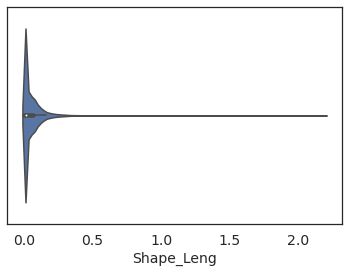

In [48]:
sns.violinplot(x=predoMaterials['Shape_Leng'])

In [60]:
def modDFToGetSmallerLengths(df):
    
    MAXLENG= 0.001

    #copy the rows that are larger
    auxLarger=df[df['Shape_Leng']>MAXLENG].copy() 

    while not (auxLarger.shape[0]==0):

        #changes the larger in the original df with the new length
        df['Shape_Leng']= df['Shape_Leng'].where(df['Shape_Leng'] < MAXLENG, df['Shape_Leng']/2) 
        #changes the extra df
        auxLarger['Shape_Leng']= auxLarger['Shape_Leng'].where(auxLarger['Shape_Leng'] < MAXLENG, auxLarger['Shape_Leng']/2) 
        #Join both df
        df=pd.concat([df, auxLarger])
        #creates the extra rows
        auxLarger=df[df['Shape_Leng']>MAXLENG].copy()
        
    return df
    

dfFinalExp=modDFToGetSmallerLengths(dfFinal.copy())   

In [44]:
display(dfFinal['Shape_Leng'].describe())
display(dfFinalExp['Shape_Leng'].describe())

count    132184.000000
mean          0.049852
std           0.069975
min           0.000003
25%           0.003255
50%           0.020617
75%           0.072100
max           2.195685
Name: Shape_Leng, dtype: float64

count    4.773498e+06
mean     1.380463e-03
std      2.850116e-04
min      2.886174e-06
25%      1.136643e-03
50%      1.325037e-03
75%      1.596496e-03
max      1.999999e-03
Name: Shape_Leng, dtype: float64

<AxesSubplot:xlabel='Shape_Leng'>

<AxesSubplot:xlabel='Shape_Leng'>

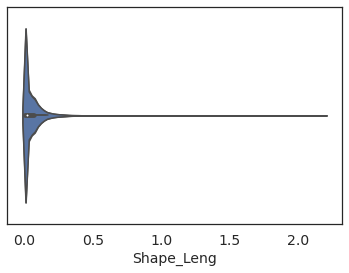

In [45]:
sns.violinplot(x=dfFinal['Shape_Leng'])

<AxesSubplot:xlabel='Shape_Leng'>

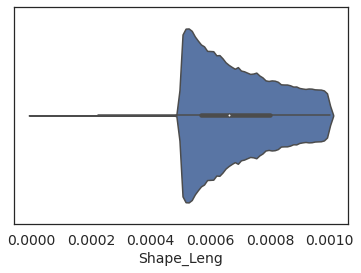

In [61]:
sns.violinplot(x=dfFinalExp['Shape_Leng'])

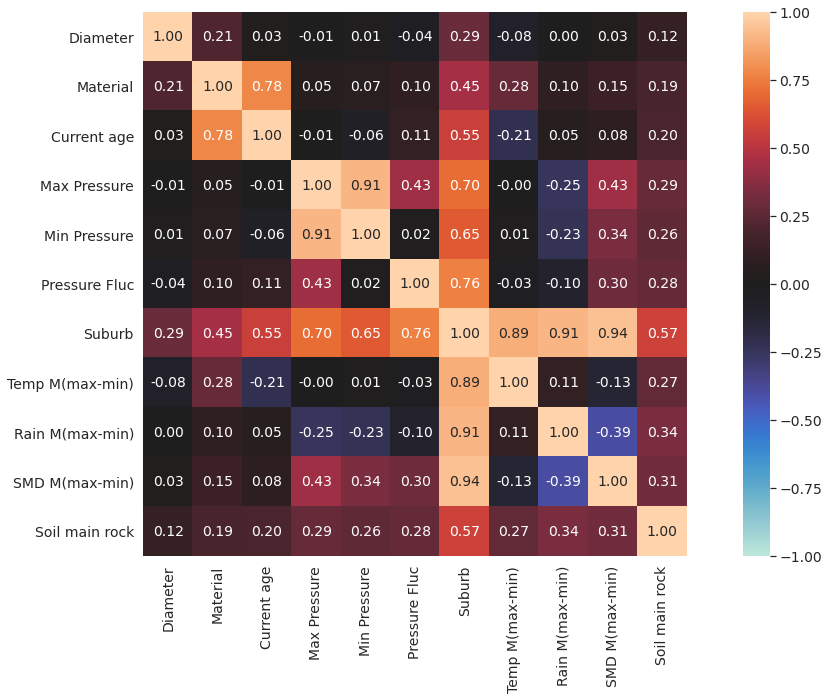

,Diameter,Material,Current age,Max Pressure,Min Pressure,Pressure Fluc,Suburb,Temp M(max-min),Rain M(max-min),SMD M(max-min),Soil main rock
Diameter,1.000000,0.213103,0.026431,-0.006360,0.011797,-0.040574,0.289928,-0.081897,0.004420,0.029821,0.117189
Material,0.213103,1.000000,0.776282,0.052929,0.066993,0.098818,0.445432,0.284237,0.095817,0.148130,0.193450
Current age,0.026431,0.776282,1.000000,-0.009747,-0.063405,0.113211,0.554737,-0.214760,0.048736,0.082507,0.196484
Max Pressure,-0.006360,0.052929,-0.009747,1.000000,0.908049,0.432589,0.704171,-0.000809,-0.248128,0.430072,0.285884
Min Pressure,0.011797,0.066993,-0.063405,0.908049,1.000000,0.015168,0.651041,0.012578,-0.228473,0.338475,0.258250
Pressure Fluc,-0.040574,0.098818,0.113211,0.432589,0.015168,1.000000,0.763682,-0.029006,-0.100536,0.298085,0.275317
Suburb,0.289928,0.445432,0.554737,0.704171,0.651041,0.763682,1.000000,0.887202,0.908040,0.937578,0.565152
Temp M(max-min),-0.081897,0.284237,-0.214760,-0.000809,0.012578,-0.029006,0.887202,1.000000,0.109554,-0.132602,0.271854
Rain M(max-min),0.004420,0.095817,0.048736,-0.248128,-0.228473,-0.100536,0.908040,0.109554,1.000000,-0.393503,0.335968
SMD M(max-min),0.029821,0.148130,0.082507,0.430072,0.338475,0.298085,0.937578,-0.132602,-0.393503,1.000000,0.310747


In [64]:
createCrossVaGraph(dfFinalExp.drop(columns=['Shape_Leng']))

# Validate correlation matrix -----------------------

In [15]:
def getCorrelationMatrix(mDf):
    
    variables= mDf.drop(columns=['Shape_Leng',STATUS,MATERIAL,INSTALLED,'Num of failures']).copy()
    
    display(variables.head(1))
    
    weights= mDf[['Shape_Leng']].copy()

    des= smS.DescrStatsW(variables, weights=weights)
        
    return des


,Diameter,Age Today,Max Pressure,Min Pressure,Pressure Fluc
COMPKEY,,,,,
21006974,150.0,45.0,71.944733,63.848888,8.09584


In [14]:
fAux= joinWithPressure(predoMaterials.copy())

fAux= fAux.rename(columns={NOM_DIA_MM:DIAMETER,MATERIAL:MATERIAL,'MOD_MAXPRE':'Max Pressure',
                                    'MOD_MINPRE':'Min Pressure','Press_fluc':'Pressure Fluc'})

fAux.dropna(inplace=True)

Total Length of pipes with pressure (GIS) 9172.63  in  198694 records
Total Length of pipes with VALID distance to pressure (GIS) 6864.60  in  137710 records


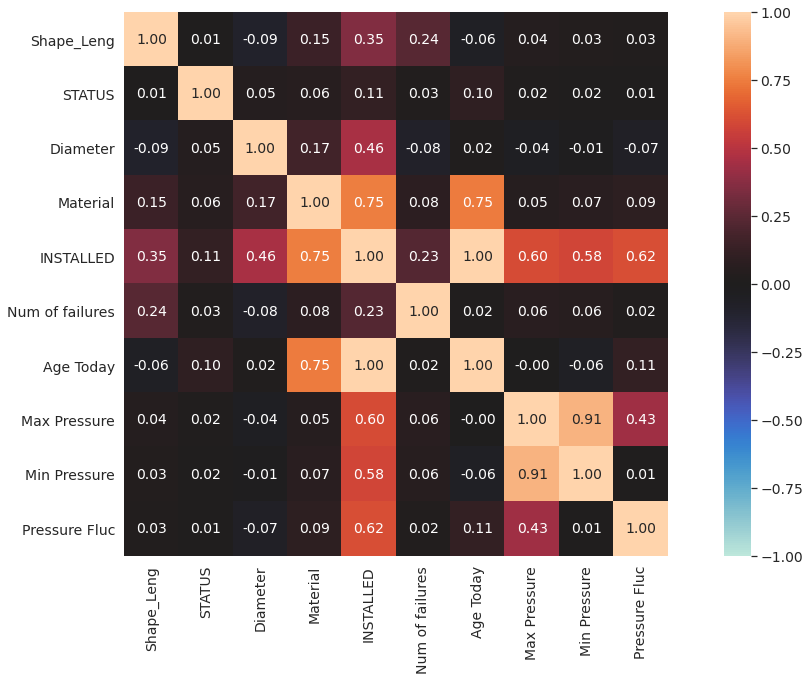

'corr'

In [21]:
createCrossVaGraph(fAux.copy())

In [39]:
#compare the raw df with both software without weights both

auxPrueba= predoMaterials.copy()

auxPrueba['Shape_Leng']=1

weights= auxPrueba['Shape_Leng']

auxPrueba= auxPrueba.drop(columns=['Shape_Leng',STATUS,MATERIAL,INSTALLED,'Num of failures']).copy()
    
des= smS.DescrStatsW(auxPrueba, weights=weights)

display(des.corrcoef)

result= associations(dataset=auxPrueba,compute_only=True)

result['corr']



array([[ 1.        , -0.04307061],
       [-0.04307061,  1.        ]])

,NOM_DIA_MM,Age Today
NOM_DIA_MM,1.000000,-0.043071
Age Today,-0.043071,1.000000


In [38]:
#Compare the manually weighted df with both libraries

prueba2= modDFToGetSmallerLengths(predoMaterials.copy())

prueba2['Shape_Leng']=1

weights= prueba2['Shape_Leng']

prueba2= prueba2.drop(columns=['Shape_Leng',STATUS,MATERIAL,INSTALLED,'Num of failures']).copy()
    
des= smS.DescrStatsW(prueba2, weights=weights)

display(des.corrcoef)

result= associations(dataset=prueba2,compute_only=True)

result['corr']

array([[ 1.        , -0.04586351],
       [-0.04586351,  1.        ]])

,NOM_DIA_MM,Age Today
NOM_DIA_MM,1.000000,-0.045864
Age Today,-0.045864,1.000000


In [50]:
#compare by weights and by fake weights

#with weigths
prueba3=dfFinal.copy()
weights= prueba3['Shape_Leng']
prueba3= prueba3.drop(columns=['Shape_Leng',MATERIAL,SUBURB,'Soil main rock']).copy()
    
des= smS.DescrStatsW(prueba3, weights=weights)

resulDf= pd.DataFrame(des.corrcoef,columns=prueba3.columns.tolist())

prueba3Ext= dfFinalExp.copy()
prueba3Ext= prueba3Ext.drop(columns=['Shape_Leng',MATERIAL,SUBURB,'Soil main rock']).copy()

result= associations(dataset=prueba3Ext,compute_only=True)

result['corr']

,Diameter,Age Today,Max Pressure,Min Pressure,Pressure Fluc,Temp M(max-min),Rain M(max-min),SMD M(max-min)
Diameter,1.000000,0.026353,-0.006406,0.011771,-0.040624,-0.081953,0.004434,0.029797
Age Today,0.026353,1.000000,-0.009718,-0.063327,0.113098,-0.214698,0.048573,0.082538
Max Pressure,-0.006406,-0.009718,1.000000,0.908025,0.432570,-0.000513,-0.247917,0.430031
Min Pressure,0.011771,-0.063327,0.908025,1.000000,0.015089,0.012769,-0.228353,0.338469
Pressure Fluc,-0.040624,0.113098,0.432570,0.015089,1.000000,-0.028705,-0.100273,0.297957
Temp M(max-min),-0.081953,-0.214698,-0.000513,0.012769,-0.028705,1.000000,0.109482,-0.132433
Rain M(max-min),0.004434,0.048573,-0.247917,-0.228353,-0.100273,0.109482,1.000000,-0.393451
SMD M(max-min),0.029797,0.082538,0.430031,0.338469,0.297957,-0.132433,-0.393451,1.000000


# Start Coordinates analysis ----------------------------------------------------

In [8]:
def getCoordinates(df):

    # Join by vicinity of the shape file "Water_Pipe" from Nish with the file of preassures from Mike
    fGISPipesCoord = 'Data/Coordinates/CoordinatesMiddlePointAll.txt'

    GISPipesCoord = pd.read_csv(fGISPipesCoord, delimiter = ',',
                               dtype = {COMPKEY:'int64', 'LAT':'float64','LONG':'float64'},
                                usecols=[3,24,25],
                                index_col=[COMPKEY])

    GISPipesCoord = GISPipesCoord.groupby(GISPipesCoord.index).agg({'LAT': 'first', 'LONG': 'first'})

    dfNCoordinates = df.join(GISPipesCoord)
    print("Total Length of pipes with coordinates (GIS)", "%.2f" % dfNCoordinates['Shape_Leng'].sum(), " in ",  dfNCoordinates.shape[0], "records")
    assert df.shape[0] == dfNCoordinates.shape[0]
    
    print("MaxLat:",dfNCoordinates['LAT'].max(),"MinLat:",dfNCoordinates['LAT'].min())
    print("MaxLong:",dfNCoordinates['LONG'].max(),"MinLong:",dfNCoordinates['LONG'].min())
    
    return dfNCoordinates


def getCoordinatesGrouped(df,material):
    
    dfm=df[df[MATERIAL]== material].copy()
    
    dfm['LAT']= dfm['LAT'].round(0)
    dfm['LONG']= dfm['LONG'].round(0)
    
    dfGrouped= dfm.groupby(["LAT","LONG"]).agg({'Shape_Leng':sum, 'Num of failures': sum}).copy()
    
    dfGrouped['Failures/Km/year']= (dfGrouped['Num of failures']/dfGrouped['Shape_Leng']/6).replace(0, np.NAN)
    dfGrouped= dfGrouped.dropna()
    
    #remove outliners
    iqr = dfGrouped.quantile(0.75, numeric_only=False) - dfGrouped.quantile(0.25, numeric_only=False)
    limN = np.abs((dfGrouped - dfGrouped.median()) / iqr) < 2.22

    #https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame
    
    # replace outliers with nan
    dfGrouped['Failures/Km/year'] = dfGrouped.where(limN, np.nan)
    dfGrouped= dfGrouped.dropna()
    
    dfGrouped= dfGrouped.reset_index()
    
    return dfGrouped


def getCoordinatesHeatMap(df):
    
    dfCoor= getCoordinates(df)
    
    for m in MATERIALS_PREDOMI:
        
        mDf = getCoordinatesGrouped(dfCoor.copy(),m)
    
        fig, ax = plt.subplots(figsize=(11,20))
        
        print(mDf['Failures/Km/year'].min(), " ", mDf['Failures/Km/year'].max())

        sc = ax.scatter(mDf.LAT, mDf.LONG, c=mDf['Failures/Km/year'],cmap='cool',vmin=0,vmax=0.4)
        
        fig.colorbar(sc, ax=ax)
        
        ax.set_xlim([1727960,1783925])
        ax.set_ylim([5874605,5983394])
        

# End Coordinates analysis ----------------------------------------------------

In [ ]:
def expandDfPerMonth(df):

    sdate=dt2.date(2013, 3, 1)
    edate=dt2.date(2020, 1, 1)
    dates= pd.date_range(sdate,edate,freq='M')
    ori= df.shape[0]

    df['Month']= 2
    df['Year']= 2013
    auxO=df.copy()

    for d in dates:

        auxC= auxO.copy()
        auxC['Month']= d.month
        auxC['Year']= d.year
        df=df.append(auxC)
    
    assert df.shape[0] == ori*(len(dates)+1)
        
    return df


def joinWithFailuresOLD(dfMains,dfFailures):
    
    #Modify the dfFailures to leve only one row per pipe , month and year of failure
    dfFailures["Month"]= dfFailures[ADDDTTM].dt.month
    dfFailures["Year"]= dfFailures[ADDDTTM].dt.year
    dfFailures= validateYearsMaterials(dfFailures)
    dfFail= dfFailures.groupby(["COMPKEY","Year","Month"]).agg({'Age at failure':'mean', ADDDTTM: 'count'}).copy()
    dfFail.rename(columns={"ADDDTTM": "Num of failures"},inplace=True)
    
    assert dfFailures.shape[0] == dfFail['Num of failures'].sum()

    #Expands the dfMains to mains x each month in the evaluation period (2014-2020)
    df=expandDfPerMonth(dfMains)
    df.set_index(['Month',"Year"], append=True,inplace=True) #adds month and year to compkey
    
    #join with number of failures
    dfN=df.join(dfFail).copy()
    dfN['Num of failures']=dfN['Num of failures'].fillna(0)
    assert df.shape[0] == dfN.shape[0]
    assert dfFailures.shape[0] == dfN['Num of failures'].sum()
    
    return dfN

#Gets a table of records failures columns values of the pipe and climate of the failure month
def addClimateToAll(dfPipes,dfAll):
    
    climateVals= getClimateData()
    
    #Get the station of each pipe
    dfStations=getPipesVsStations(dfPipes)[['Station Temperature','Station Rain']].copy()
    
    #Attach the stations to the all
    dfAllSta= dfAll.join(dfStations)
    assert dfAll.shape[0] == dfAllSta.shape[0]
    
    for climate, sta,v in zip(climateVals,['Station Temperature','Station Rain','Station Rain'],
                             ["Temperature","Rain","SMD"]):
       
        cli=climate.rename(columns={'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7, 'Aug':8,
                                'Sep':9,'Oct':10,'Nov':11,'Dec':12, 'Station': sta,'Year ':"Year"})

        cli=cli.drop(['Stats_Code','Annual'], axis=1).set_index([sta,'Year']).copy()
        cli=pd.melt(cli,var_name="Month",value_name=v,ignore_index = False)
        
        cli.set_index(['Month'], append=True,inplace=True)

        
        #Join pipesDates with climate
        dfAllSta= (dfAllSta.reset_index().set_index([sta,'Month','Year'])).join(cli).copy()
        assert dfAll.shape[0] == dfAllSta.shape[0]
        
    dfAllFinal=dfAllSta.reset_index().set_index([COMPKEY,'Month','Year']).drop(['Station Temperature','Station Rain'], axis=1)

    return dfAllFinal

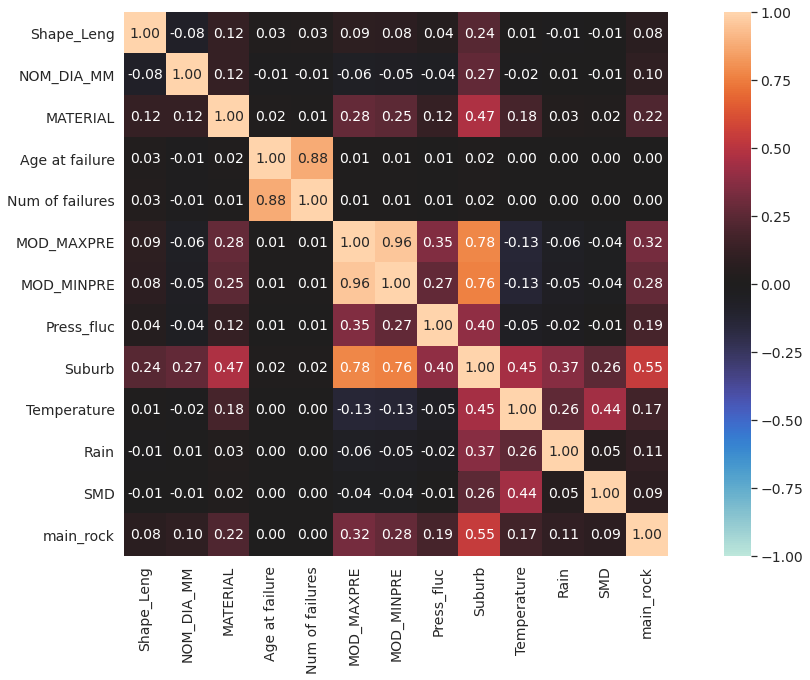

{'corr':                  Shape_Leng  NOM_DIA_MM  MATERIAL  Age at failure  \
 Shape_Leng         1.000000   -0.077889  0.121513        0.030154   
 NOM_DIA_MM        -0.077889    1.000000  0.119435       -0.010885   
 MATERIAL           0.121513    0.119435  1.000000        0.015778   
 Age at failure     0.030154   -0.010885  0.015778        1.000000   
 Num of failures    0.033987   -0.012022  0.012332        0.877934   
 MOD_MAXPRE         0.086922   -0.060251  0.275716        0.011774   
 MOD_MINPRE         0.081754   -0.051486  0.252726        0.011613   
 Press_fluc         0.039806   -0.042456  0.120122        0.005273   
 Suburb             0.238718    0.270088  0.469197        0.018180   
 Temperature        0.010467   -0.015428  0.184836        0.002976   
 Rain              -0.011070    0.006232  0.031318        0.002555   
 SMD               -0.005436   -0.005525  0.024264        0.003308   
 main_rock          0.076571    0.099562  0.216511        0.003446   
 
          

In [19]:
OLD (per month )